# this module will implement a 3D renderer for cubes
# ideally, code this so that it is not that hard to make it in verilog

In [218]:
from IPython.display import display 
from PIL import Image

In [219]:
# import image
img = Image.open("realcat.png")

In [220]:
# display image
def display_image():
    display(img)

In [221]:
def zero_image():
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            img.putpixel((i, j), (0, 0, 0))

In [222]:
# definitions

u = (0, 1, 0)
v = (0, 0, 1)
e = (800, 100, 0)
w = 1024
h = 768

blocks_pos = [(300, 300, -100), (150, 100, 25), (-100, -200, -100)]
blocks_mat = [(1, 0, 0, 0.5), (0, 0, 1, 0.5), (0, 1, 0, 0.5)] # ranges from 0 to 1, diffuse RGB and reflection
lights_pos = [(800, 100, 0)]
lights_intense = [(1, 1, 1)] # colored lights

In [223]:
# helper functions
def scale(v, c):
    return (v[0] * c, v[1] * c, v[2] * c)
def size(v):
    return dot(v, v)**0.5
def add(v1, v2):
    return (v1[0] + v2[0], v1[1] + v2[1], v1[2] + v2[2])
def sub(v1, v2):
    return (v1[0] - v2[0], v1[1] - v2[1], v1[2] - v2[2])
def dot(v1, v2):
    return (v1[0] * v2[0]) + (v1[1] * v2[1]) + (v1[2] * v2[2])

In [224]:
def eye_to_pixel(x, y):
    us = (-w/2) + x
    vs = (-h/2) + y
    dir = sub(add(scale(u, us), scale(v, vs)), e)
    dir = scale(dir, 1/size(dir))
    return dir

In [225]:
def ray_block_intersection(ray, block_pos, radius, block_mat, t):
    dist = sub(e, block_pos)
    a = dot(ray, ray)
    b = 2 * dot(ray, dist)
    c = dot(dist, dist) - (radius * radius)
    discr = (b * b) - (4 * a * c)

    if discr >= 0:
        sqrtdiscr = discr**0.5

        if b >= 0:
            sol1 = (-b - sqrtdiscr) / (2 * a)
            sol2 = (2 * c) / (-b - sqrtdiscr)
            new_t = min(sol1, sol2)
        else:
            sol1 = (2 * c) / (-b + sqrtdiscr)
            sol2 = (-b + sqrtdiscr) / (2 * a)
            new_t = min(sol1, sol2)
        
        if new_t > 0 and new_t < t[0]:
            t[0] = new_t
            return True
    
    return False

# print(ray_block_intersection(eye_to_pixel(612, 415), (150, 100, 25), 1, (1, 1, 1), [10000000]))

In [226]:
def get_pixel_color(block_pos, block_mat, ray, x, y, t):
    newOrigin = add(e, scale(ray, t[0]))
    normal = sub(newOrigin, block_pos)
    normal_magnitude = size(normal)

    if normal == 0:
        return (0, 0, 0)
    
    normal = scale(normal, 1/normal_magnitude)

    r = 0.0
    g = 0.0
    b = 0.0
    for i in range(len(lights_pos)):
        light_pos = lights_pos[i]
        light_intense = lights_intense[i]
        dist = sub(light_pos, newOrigin)

        if dot(normal, dist) <= 0:
            continue
        
        rayDir = scale(dist, 1/size(dist))

        lambert = dot(rayDir, normal)

        r += (light_intense[0] * block_mat[0] * lambert)
        g += (light_intense[1] * block_mat[1] * lambert)
        b += (light_intense[2] * block_mat[2] * lambert)

    return r, g, b

def set_pixel_color(block_pos, block_mat, ray, x, y, t):
    r, g, b = get_pixel_color(block_pos, block_mat, ray, x, y, t)
    r = int(min(r, 1) * 255.0)
    g = int(min(g, 1) * 255.0)
    b = int(min(b, 1) * 255.0)
    img.putpixel((x, y), (r, g, b))

In [227]:
def render_frame():
    for y in range(h):
        for x in range(w):
            ray = eye_to_pixel(x, y)
            t = [1000000000]

            block = -1

            # opposite order
            for i in range(len(blocks_pos)):
                if ray_block_intersection(ray, blocks_pos[i], 30, blocks_mat[i], t):
                    block = i
                    break
            
            if block == -1:
                img.putpixel((x, y), (0, 0, 0))
                continue

            set_pixel_color(blocks_pos[block], blocks_mat[block], ray, x, y, t)

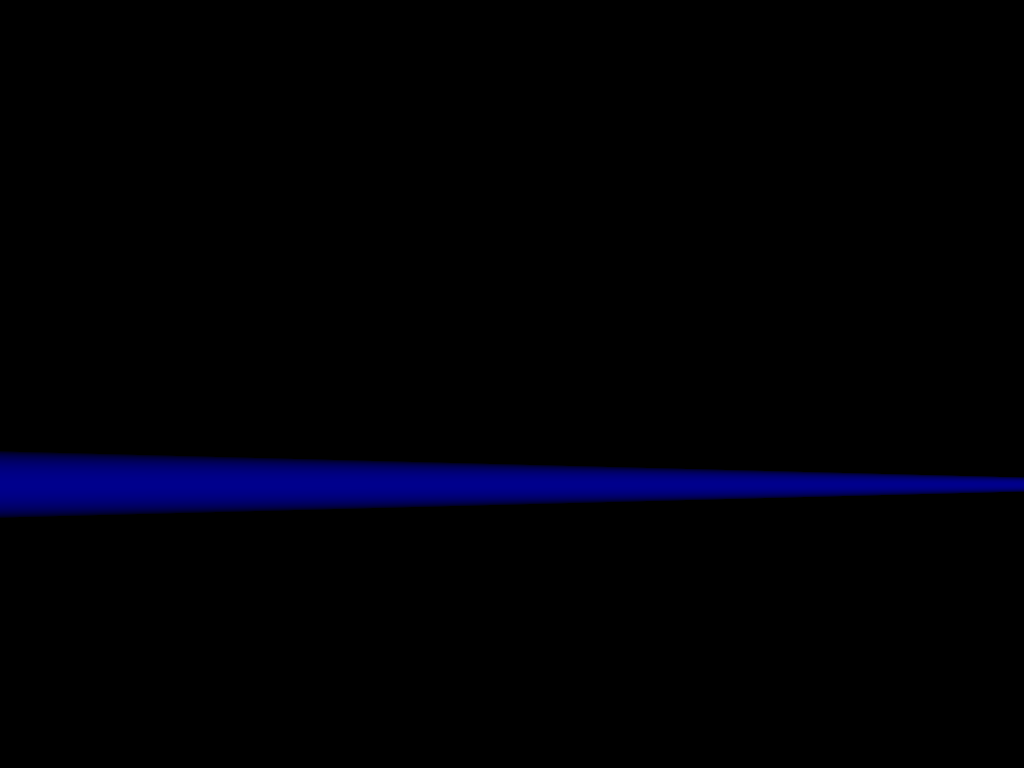

In [228]:
zero_image()
render_frame()
display_image()